In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import add as k_add
from tensorflow.keras.layers import multiply as k_multiply
from tensorflow.keras.layers import concatenate as k_concatenate

from sklearn.metrics import mean_squared_error
np.random.seed(42)

## I Build the "system" and print the ground truth

In [2]:
# System definition
def S(x, tau):
    res = np.exp(-x**2) - 0.1*tau*(np.abs(x)-4.)  
    return res

In [3]:
# data generating process
# Generate Train set
def generate_dataset(p=0.01, N_sample=1000):
    X = np.random.uniform(-4,4,N_sample)
    TAU = np.random.binomial(1, p, size=N_sample)
    XTAU = np.c_[X,TAU]
    Y = S(X,TAU)
    return XTAU, Y, X, TAU

In [4]:
# Generate Test set
p_test = 0.5
N_sample = 1000
XTAU_gt, Y_gt, X_gt, TAU_gt = generate_dataset(p=p_test, N_sample=N_sample)

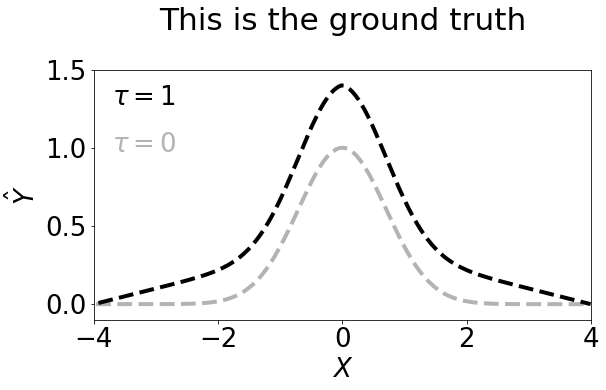

In [5]:
plt.rcParams.update({'font.size': 26})
x0_plt = np.sort(X_gt[TAU_gt==0])
index0_plt = np.argsort(X_gt[TAU_gt==0])
x1_plt = np.sort(X_gt[TAU_gt==1])
index1_plt = np.argsort(X_gt[TAU_gt==1])

plt.figure(figsize=(9,6))
plt.plot(x0_plt,Y_gt[TAU_gt==0][index0_plt], "--", label="$X_2 = 0$", linewidth=4, color="0.7")
plt.plot(x1_plt,Y_gt[TAU_gt==1][index1_plt], "--", label="$X_2 = 1$", linewidth=4, color="k")

plt.xlabel('$X$')
plt.ylabel('$\hat{Y}$')
plt.text(-3.7,1.1, r"$\tau = 0$", horizontalalignment="left", verticalalignment="top", color="0.7")
plt.text(-3.7,1.4, r"$\tau = 1$", horizontalalignment="left", verticalalignment="top", color="k")
plt.xlim((-4,4))
plt.ylim((-0.1,1.5))
plt.title("This is the ground truth\n")
plt.tight_layout()
plt.show()

# II Utility to build the models (fully connected and leap net)

These models are also available in the root directory of this github repository. It is not recommended to use this piece of code outside of here as it is meant for example and not meant to be generic

In [6]:
def build_model(nE = 1, nD = 1, ls = 20, enc = "FC", nltype="relu"):
    """
    :param nE: number of layers for encoder E
    :param nD: number of layers for decoder D
    :param ls: size of each layer
    :param enc: one of "FC" / "LEAP" the model considered
    """
    x = Input(shape=(1,))
    tau = Input(shape=(1,))
    
    # build the input of the model
    if enc == "FC" or enc == "ResNet" :
        x_ = k_concatenate([x, tau])  # in the fully connected, the neural network uses a concantenation of x and tau
    elif enc == "LEAP":
        x_ = x
    else:
        raise RuntimeError("Unknown encoding \"{}\"".format(enc))
    tmp = x_

    # enoder (denoted by E)
    for _ in range(nE):
        tmp = Dense(ls)(tmp)
        tmp = Activation(nltype)(tmp)
    E_out = tmp

    # leap part (L_tau)
    if enc == "LEAP":
        tmp = Dense(1)(E_out) # e
        tmp = k_multiply([tau, tmp])  # element wise multiplication
        tmp = Dense(ls, use_bias=False)(tmp) # d
        d_in = k_add([E_out, tmp])
    elif enc == "FC":
        d_in = E_out
    elif enc == "ResNet":
        tmp = Dense(1)(E_out)
        tmp = Activation(nltype)(tmp)
        tmp = Dense(ls)(tmp)
        d_in = k_add([E_out, tmp])
    else:
        raise RuntimeError("Unknown encoding \"{}\"".format(enc))
    
    # decoder (denoted by D)
    tmp = d_in
    for _ in range(nD):
        tmp = Dense(ls)(tmp)
        tmp = Activation(nltype)(tmp)
    D_out = tmp
    
    # last layer
    res_model = Dense(1)(tmp)


    res = Model(inputs=[x, tau], outputs=[res_model])
    return res

def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

# III Reproduce plot of figures 3 and 4

**NB** The display of the figures may change due to random seeds and use of stochastic gradient descent.

In [7]:
# optimizer parameter
lr = 0.001
max_iter = 2000
batch_size=32

# models parameters
nE = 5
nD = 1
ls = 10

# Data parameters
N_sample = 1000
p_train = 0.01
p_test = 0.5

In [8]:
# generate datasets
## training set
X_TAU_train, Y_train, X_train, TAU_train = generate_dataset(p=p_train, N_sample=N_sample)
print(r"There are {} training points with $\tau=1$".format(np.sum(TAU_train==1)))
## test set
X_TAU_test, Y_test, X_test, TAU_test = generate_dataset(p=p_test, N_sample=N_sample)

There are 10 training points with $\tau=1$


### III a Train the models

The next cell will train 4 models on the training set defined above. On a laptop, with only CPU it takes roughly 10-15mins.

In [9]:
# leap net
## build it
adam_leap = tf.optimizers.Adam(lr=lr)
leap_model = build_model(nE=nE, nD=nD, ls=ls, enc="LEAP")
leap_model.compile(optimizer=adam_leap, loss='mse')
## train it
leap_model.fit(x=[X_train, TAU_train], y=[Y_train], epochs=max_iter, verbose=False)
## evaluate it
Y_pred_leap = leap_model.predict([X_test, TAU_test])
Y_pred_leap_train = leap_model.predict([X_train, TAU_train])

# vanilla fully connected
## build it
adam_fc = tf.optimizers.Adam(lr=lr)
fc_model = build_model(nE=nE, nD=nD, ls=ls, enc="FC")
fc_model.compile(optimizer=adam_fc, loss='mse')
# train it
fc_model.fit(x=[X_train, TAU_train], y=[Y_train], epochs=max_iter, verbose=False)
## evaluate it
Y_pred_fc = fc_model.predict([X_test, TAU_test])
Y_pred_fc_train = fc_model.predict([X_train, TAU_train])


# ResNet fully connected
adam_rn = tf.optimizers.Adam(lr=lr)
rn_model = build_model(nE=nE, nD=nD, ls=ls, enc="ResNet")
rn_model.compile(optimizer=adam_rn, loss='mse')
rn_model.fit(x=[X_train, TAU_train], y=[Y_train], epochs=max_iter, verbose=False, batch_size=batch_size)
Y_pred_rn = rn_model.predict([X_test, TAU_test])
Y_pred_rn_train = rn_model.predict([X_train, TAU_train])

# over sampling the cases the less freqent
adam_os = tf.optimizers.Adam(lr=lr)
os_model = build_model(nE=nE, nD=nD, ls=ls, enc="ResNet")
os_model.compile(optimizer=adam_os, loss='mse')
weights = np.ones(TAU_train.shape, dtype=np.float32)
weights[TAU_train == 0] = np.float32(1. / (1.-p_train))
weights[TAU_train == 1] = np.float32(1. / (p_train))
os_model.fit(x=[X_train, TAU_train], y=[Y_train], epochs=max_iter, verbose=False, batch_size=batch_size,
            sample_weight=weights)
Y_pred_os = os_model.predict([X_test, TAU_test])
Y_pred_os_train = os_model.predict([X_train, TAU_train])

W0501 12:59:03.176624 140518159824192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


### III d) Figure 3

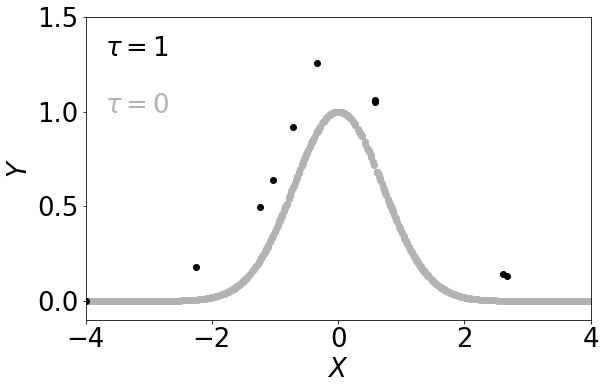

In [10]:
plt.rcParams.update({'font.size': 26})
plt.figure(figsize=(9,6))
plt.scatter(X_train[TAU_train==0],Y_train[TAU_train==0], label="$X_2 = 0$", c="0.7")
plt.scatter(X_train[TAU_train==1],Y_train[TAU_train==1], label="$X_2 = 1$", c="k")
#plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.text(-3.7,1.1, r"$\tau = 0$", horizontalalignment="left", verticalalignment="top", color="0.7")
plt.text(-3.7,1.4, r"$\tau = 1$", horizontalalignment="left", verticalalignment="top", color="k")
plt.xlim((-4,4))
plt.ylim((-0.1,1.5))
plt.tight_layout()
plt.show()

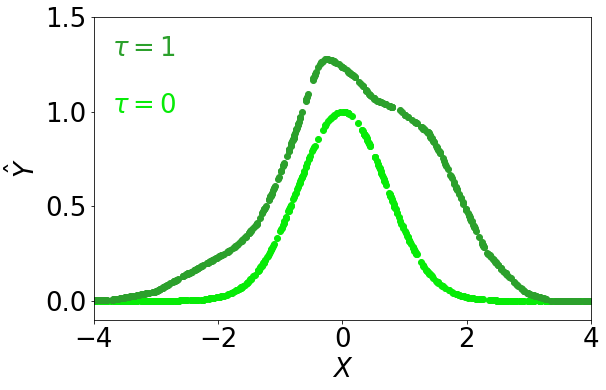

In [11]:
plt.rcParams.update({'font.size': 26})
plt.figure(figsize=(9,6))
plt.scatter(X_test[TAU_test==0],Y_pred_fc[TAU_test==0], label="$X_2 = 0$", c="#07eb07")
plt.scatter(X_test[TAU_test==1],Y_pred_fc[TAU_test==1], label="$X_2 = 1$", c="#2ca02c")
# plt.legend()
plt.xlabel('$X$')
plt.ylabel('$\hat{Y}$')
plt.text(-3.7,1.1, r"$\tau = 0$", horizontalalignment="left", verticalalignment="top", color="#07eb07")
plt.text(-3.7,1.4, r"$\tau = 1$", horizontalalignment="left", verticalalignment="top", color="#2ca02c")
plt.xlim((-4,4))
plt.ylim((-0.1,1.5))
plt.tight_layout()
plt.show()

### III c) Figure 5

/home/donnotben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/donnotben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/donnotben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/donnotben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the p

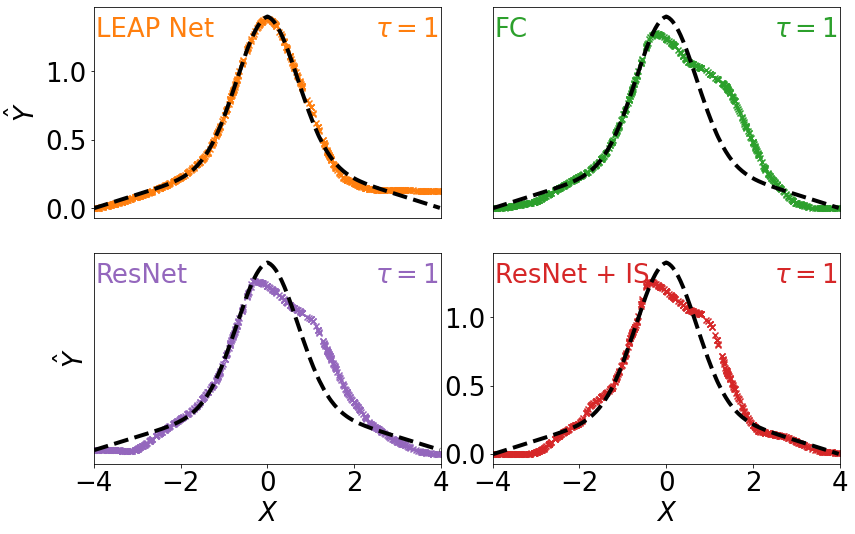

In [12]:
# start the figures

plt.rcParams.update({'font.size': 26})
loc_ = 'lower center'
fig, axs = plt.subplots(2, 2, figsize=[12,8])

x_plt = np.sort(X_test[TAU_test==1])
index_plt = np.argsort(X_test[TAU_test==1])
pos_text_x = 3.95

ax = axs[0,0]
ax.plot(x_plt,Y_test[TAU_test==1][index_plt], "--", label="Ground Truth", linewidth=4, c="k")
ax.scatter(X_test[TAU_test==1],Y_pred_leap[TAU_test==1], label="Leap Net", marker="x", c="#ff7f0e")
ax.set_ylabel('$\hat{Y}$')
ax.text(-pos_text_x,1.4, r"LEAP Net", horizontalalignment="left", verticalalignment="top", color="#ff7f0e")
ax.text(pos_text_x,1.4, r"$\tau = 1$", horizontalalignment="right", verticalalignment="top", color="#ff7f0e")
ax.set_xlim((-4,4))
ax.set_xticks([], [])

ax = axs[0,1]
ax.plot(x_plt,Y_test[TAU_test==1][index_plt], "--", label="Ground Truth", linewidth=4, c="k")
ax.scatter(X_test[TAU_test==1],Y_pred_fc[TAU_test==1], label="Fully Connected", c="#2ca02c", marker="x")
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.text(-pos_text_x,1.4, r"FC", horizontalalignment="left", verticalalignment="top", color="#2ca02c")
ax.text(pos_text_x,1.4, r"$\tau = 1$", horizontalalignment="right", verticalalignment="top", color="#2ca02c")
ax.set_xlim((-4,4))

ax = axs[1,1]
ax.plot(x_plt,Y_test[TAU_test==1][index_plt], "--", label="Ground Truth", linewidth=4, c="k")
ax.scatter(X_test[TAU_test==1],Y_pred_os[TAU_test==1], label="ResNet + IS", c="#d62728", marker="x")
ax.set_xlabel('$X$')
ax.text(-pos_text_x,1.4, r"ResNet + IS", horizontalalignment="left", verticalalignment="top", color="#d62728")
ax.text(pos_text_x,1.4, r"$\tau = 1$", horizontalalignment="right", verticalalignment="top", color="#d62728")
ax.set_xlim((-4,4))

ax = axs[1,0]
ax.plot(x_plt,Y_test[TAU_test==1][index_plt], "--", label="Ground Truth", linewidth=4, c="k")
ax.scatter(X_test[TAU_test==1],Y_pred_rn[TAU_test==1], label="ResNet", c="#9467bd", marker="x")
ax.set_xlabel('$X$')
ax.set_ylabel('$\hat{Y}$')
ax.set_yticks([], [])
ax.text(-pos_text_x,1.4, r"ResNet", horizontalalignment="left", verticalalignment="top", color="#9467bd")
ax.text(pos_text_x,1.4, r"$\tau = 1$", horizontalalignment="right", verticalalignment="top", color="#9467bd")
ax.set_xlim((-4,4))
fig.tight_layout()
plt.show()

### III b Look at results and display error (not included in paper)

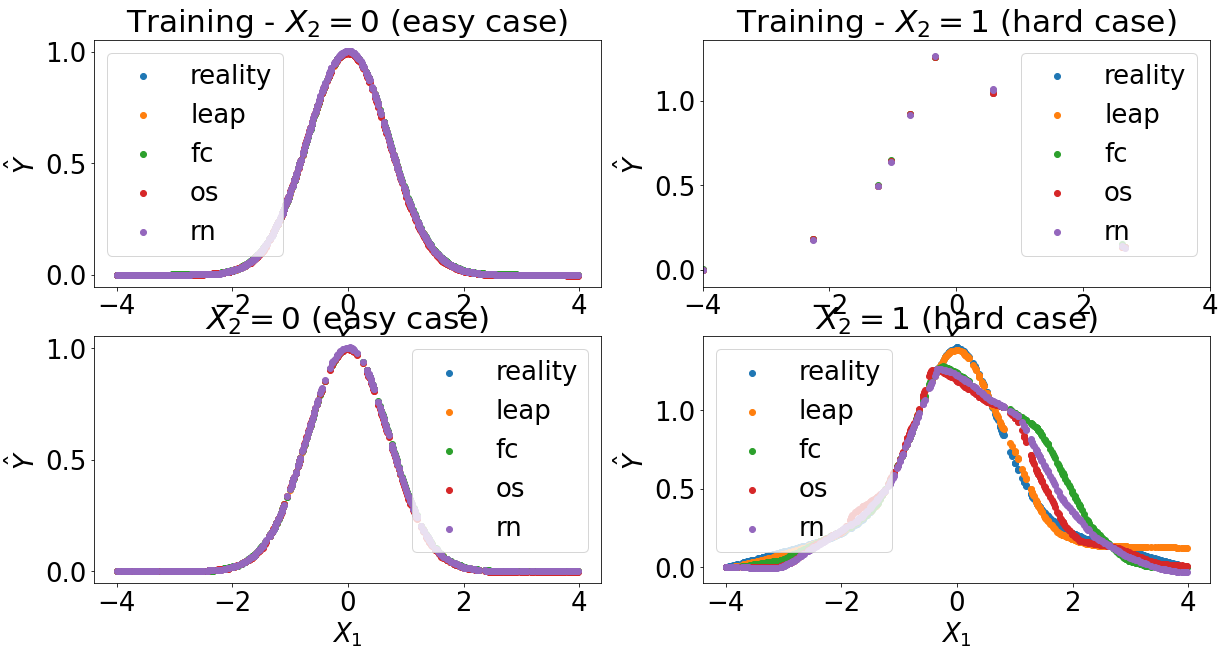

LEAP: MSE on test set: 0.0004981331873182825
LEAP: MSE x2 = -1 (easy): 3.3772952567830945e-07
LEAP: MSE x2 = 1 (hard): 0.001010064824439683
---------------------------
FC: MSE on test set: 0.01407072488256009
FC: MSE x2 = -1 (easy): 4.264890893470019e-06
FC: MSE x2 = 1 (hard): 0.028536638099142198
---------------------------
OverSamp: MSE on test set: 0.004543094712264479
OverSamp: MSE x2 = -1 (easy): 1.3618501550502455e-05
OverSamp: MSE x2 = 1 (hard): 0.009201197022268508
---------------------------
ResNet: MSE on test set: 0.007579457183052557
ResNet: MSE x2 = -1 (easy): 2.8047192190306253e-06
ResNet: MSE x2 = 1 (hard): 0.015371268134702855


In [13]:
# display the predictions
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
ax = axs[1,0]
ax.scatter(X_test[TAU_test==0],Y_test[TAU_test==0], label="reality")
ax.scatter(X_test[TAU_test==0],Y_pred_leap[TAU_test==0], label="leap")
ax.scatter(X_test[TAU_test==0],Y_pred_fc[TAU_test==0], label="fc")
ax.scatter(X_test[TAU_test==0],Y_pred_os[TAU_test==0], label="os")
ax.scatter(X_test[TAU_test==0],Y_pred_rn[TAU_test==0], label="rn")
ax.legend()
ax.set_xlabel('$X_1$')
ax.set_ylabel('$\hat{Y}$')
ax.set_title("$X_2 = 0$ (easy case)")

ax = axs[1,1]
ax.scatter(X_test[TAU_test==1],Y_test[TAU_test==1], label="reality")
ax.scatter(X_test[TAU_test==1],Y_pred_leap[TAU_test==1], label="leap")
ax.scatter(X_test[TAU_test==1],Y_pred_fc[TAU_test==1], label="fc")
ax.scatter(X_test[TAU_test==1],Y_pred_os[TAU_test==1], label="os")
ax.scatter(X_test[TAU_test==1],Y_pred_rn[TAU_test==1], label="rn")
ax.legend()
ax.set_xlabel('$X_1$')
ax.set_ylabel('$\hat{Y}$')
ax.set_title("$X_2 = 1$ (hard case)")

ax = axs[0,0]
ax.scatter(X_train[TAU_train==0],Y_train[TAU_train==0], label="reality")
ax.scatter(X_train[TAU_train==0],Y_pred_leap_train[TAU_train==0], label="leap")
ax.scatter(X_train[TAU_train==0],Y_pred_fc_train[TAU_train==0], label="fc")
ax.scatter(X_train[TAU_train==0],Y_pred_os_train[TAU_train==0], label="os")
ax.scatter(X_train[TAU_train==0],Y_pred_rn_train[TAU_train==0], label="rn")
ax.legend()
ax.set_xlabel('$X_1$')
ax.set_ylabel('$\hat{Y}$')
ax.set_title("Training - $X_2 = 0$ (easy case)")

ax = axs[0,1]
ax.scatter(X_train[TAU_train==1],Y_train[TAU_train==1], label="reality")
ax.scatter(X_train[TAU_train==1],Y_pred_leap_train[TAU_train==1], label="leap")
ax.scatter(X_train[TAU_train==1],Y_pred_fc_train[TAU_train==1], label="fc")
ax.scatter(X_train[TAU_train==1],Y_pred_os_train[TAU_train==1], label="os")
ax.scatter(X_train[TAU_train==1],Y_pred_rn_train[TAU_train==1], label="rn")
ax.legend()
ax.set_xlabel('$X_1$')
ax.set_ylabel('$\hat{Y}$')
ax.set_title("Training - $X_2 = 1$ (hard case)")
ax.set_xlim((-4,4))
ax.set_ylim((np.min([0, np.min(Y_pred_leap_train[TAU_train==1]), np.min(Y_pred_fc_train[TAU_train==1])]) - 0.1,
             np.max([1, np.max(Y_pred_leap_train[TAU_train==1]), np.max(Y_pred_fc_train[TAU_train==1])]) +0.1 ))

plt.show()

print("LEAP: MSE on test set: {}".format(mean_squared_error(Y_test, Y_pred_leap)))
print("LEAP: MSE x2 = -1 (easy): {}".format(mean_squared_error(Y_test[TAU_test==0], Y_pred_leap[TAU_test==0])))
print("LEAP: MSE x2 = 1 (hard): {}".format(mean_squared_error(Y_test[TAU_test==1], Y_pred_leap[TAU_test==1])))
print("---------------------------")
print("FC: MSE on test set: {}".format(mean_squared_error(Y_test, Y_pred_fc)))
print("FC: MSE x2 = -1 (easy): {}".format(mean_squared_error(Y_test[TAU_test==0], Y_pred_fc[TAU_test==0])))
print("FC: MSE x2 = 1 (hard): {}".format(mean_squared_error(Y_test[TAU_test==1], Y_pred_fc[TAU_test==1])))
print("---------------------------")
print("OverSamp: MSE on test set: {}".format(mean_squared_error(Y_test, Y_pred_os)))
print("OverSamp: MSE x2 = -1 (easy): {}".format(mean_squared_error(Y_test[TAU_test==0], Y_pred_os[TAU_test==0])))
print("OverSamp: MSE x2 = 1 (hard): {}".format(mean_squared_error(Y_test[TAU_test==1], Y_pred_os[TAU_test==1])))
print("---------------------------")
print("ResNet: MSE on test set: {}".format(mean_squared_error(Y_test, Y_pred_rn)))
print("ResNet: MSE x2 = -1 (easy): {}".format(mean_squared_error(Y_test[TAU_test==0], Y_pred_rn[TAU_test==0])))
print("ResNet: MSE x2 = 1 (hard): {}".format(mean_squared_error(Y_test[TAU_test==1], Y_pred_rn[TAU_test==1])))